In [1]:
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import regularizers

from tensorflow.keras import layers
from tensorflow.keras import losses

from collections import Counter


import pandas as pd
import numpy as np

import sklearn


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


import seaborn as sns

import pydot



In [2]:

data_train = pd.read_csv('/content/full_hin.csv')
data_train.head()


Unnamed: 0                                               Text  label
0           0  Bollywood film dekhne ke samay logic ghar mein...      0
1           1                                   Chutiya movie...      0
2           2       Amrit Anand अब तो जुड़े ही है उनको बोलो जुड़ने      0
3           3  @Pankaj Chauhan abey tum jse aadmiyo ko ye lgt...      0
4           4                 bro house of card ka review karona      0

In [4]:
data_test = pd.read_csv('/content/trac2_hin_dev.csv')

In [5]:
data_test.drop(['ID','Sub-task B'], axis=1, inplace=True)

In [6]:
NAG_test = data_test[(data_test['Sub-task A']=='NAG')]
OAG_test= data_test[(data_test['Sub-task A']=='CAG')]
CAG_test = data_test[(data_test['Sub-task A']=='OAG')]

In [7]:
import warnings as wrn
wrn.filterwarnings('ignore')

NAG_test["Sub-task A"] = 0 
#negatives_test["Sentiment"] = 0

OAG_test["Sub-task A"] = 1
#positives_test["Sentiment"] = 2

CAG_test["Sub-task A"] = 2
#neutrals_test["Sentiment"] = 1

NAG_test.head()

Text  Sub-task A
1   Bhaiya shaadi mein zaroor aana movie ka plot j...           0
2   Section 375 hai kya??? .... Ye to batate kam s...           0
4              Maine itni kam dislike kbhi nhii dekhi           0
7   जिश देश मे super30 जैसी फ़िल्म फ्लॉप ओर कबीर सि...           0
11            Bhai movie review 5 se 7 mins Bano yaar           0

In [8]:

data_test = pd.concat([NAG_test,
                  OAG_test,
                  CAG_test
                 ],axis=0)

data_test.reset_index(inplace=True)


In [9]:

data_test = data_test.rename(columns = {'Sub-task A': 'label'}, inplace = False)

In [10]:
X = data_train.Text.astype(str)
Y = data_train.label
#le = LabelEncoder()
#Y = le.fit_transform(Y)
#Y = Y.reshape(-1,1)

In [11]:
X_train,X_valid,y_train,y_valid = train_test_split(X,Y,test_size=0.15)

In [12]:
num_words = 50000

tokenizer = Tokenizer(num_words=num_words,oov_token="unk")
tokenizer.fit_on_texts(X_train)


print(str(tokenizer.texts_to_sequences(['xyz how are you'])))

[[81, 3662, 220, 244]]


In [13]:

x_train = np.array( tokenizer.texts_to_sequences(X_train) )
x_valid = np.array( tokenizer.texts_to_sequences(X_valid) )
x_test  = np.array( tokenizer.texts_to_sequences(data_test['Text'].tolist()) )


In [14]:

x_train = pad_sequences(x_train, padding='post', maxlen=150)
x_valid = pad_sequences(x_valid, padding='post', maxlen=150)
x_test = pad_sequences(x_test, padding='post', maxlen=150)

In [15]:
train_labels = np.asarray(y_train )
valid_labels = np.asarray( y_valid)

test_labels = np.asarray(data_test['label'].tolist())

In [16]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,train_labels))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid,valid_labels))
test_ds = tf.data.Dataset.from_tensor_slices((x_test,test_labels))

In [17]:

max_features =50000
embedding_dim =16
sequence_length = 150

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(max_features +1, embedding_dim, input_length=sequence_length,\
                                    embeddings_regularizer = regularizers.l2(0.005))) 
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.LSTM(embedding_dim,dropout=0.2, recurrent_dropout=0.2,return_sequences=True,\
                                                             kernel_regularizer=regularizers.l2(0.005),\
                                                             bias_regularizer=regularizers.l2(0.005)))

model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(512, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))

model.add(tf.keras.layers.Dense(8, activation='relu',\
                                kernel_regularizer=regularizers.l2(0.001),\
                                bias_regularizer=regularizers.l2(0.001),))
model.add(tf.keras.layers.Dropout(0.4))


model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
                               



model.summary()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),optimizer=tf.keras.optimizers.Adam(1e-3),metrics=[tf.keras.metrics.Accuracy()])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 16)           800016    
_________________________________________________________________
dropout (Dropout)            (None, 150, 16)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 150, 16)           2112      
_________________________________________________________________
flatten (Flatten)            (None, 2400)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1229312   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 4

In [18]:
epochs = 30
# Fit the model using the train and test datasets.
#history = model.fit(x_train, train_labels,validation_data= (x_test,test_labels),epochs=epochs )
history = model.fit(train_ds.shuffle(5000).batch(1024),
                    epochs= epochs ,
                    validation_data=valid_ds.batch(1024),
                    verbose=1)

Epoch 1/30
7/7 [==============================] - 10s 821ms/step - loss: 4.0211 - accuracy: 0.0000e+00 - val_loss: 2.8864 - val_accuracy: 0.0000e+00
Epoch 2/30
7/7 [==============================] - 5s 695ms/step - loss: 2.6190 - accuracy: 0.0000e+00 - val_loss: 1.8352 - val_accuracy: 0.0000e+00
Epoch 3/30
7/7 [==============================] - 5s 690ms/step - loss: 1.6633 - accuracy: 0.0000e+00 - val_loss: 1.1819 - val_accuracy: 0.0000e+00
Epoch 4/30
7/7 [==============================] - 5s 696ms/step - loss: 1.0882 - accuracy: 3.8947e-05 - val_loss: 0.8459 - val_accuracy: 0.0000e+00
Epoch 5/30
7/7 [==============================] - 5s 710ms/step - loss: 0.8119 - accuracy: 0.1239 - val_loss: 0.7592 - val_accuracy: 0.2939
Epoch 6/30
7/7 [==============================] - 5s 701ms/step - loss: 0.7734 - accuracy: 0.2448 - val_loss: 0.8731 - val_accuracy: 0.2939
Epoch 7/30
7/7 [==============================] - 5s 701ms/step - loss: 0.9285 - accuracy: 0.2613 - val_loss: 1.1525 - val_accu

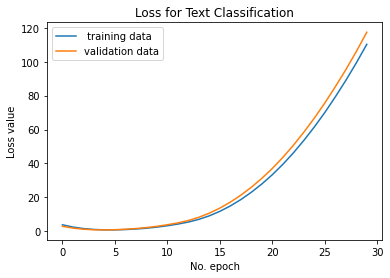

In [19]:
plt.plot(history.history['loss'], label=' training data')
plt.plot(history.history['val_loss'], label='validation data')
plt.title('Loss for Text Classification')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [20]:

x_test  = np.array( tokenizer.texts_to_sequences(data_test['Text'].tolist()) )
x_test = pad_sequences(x_test, padding='post', maxlen=150)


In [21]:

print("Generate predictions for all samples")
predictions = model.predict(x_test)

Generate predictions for all samples


In [22]:

data_test['pred']= predictions

In [23]:

labels = [0,1,2]
    
print(classification_report(data_test['label'].tolist(),data_test['pred'].tolist(),labels=labels))

              precision    recall  f1-score   support

           0       0.72      0.66      0.69       578
           1       0.24      0.53      0.33       211
           2       0.00      0.00      0.00       208

    accuracy                           0.49       997
   macro avg       0.32      0.40      0.34       997
weighted avg       0.47      0.49      0.47       997

